In [115]:
import numpy as np
from sklearn import metrics
import pandas as pd

models = [
    "davinci", "gpt-3.5-turbo", "gpt-4-0314", "text-davinci-003"
]
runs = [
    'run_1', 'run_2', 'run_3'
]

consistent_functions = []
for model in models:
    df = pd.read_csv(
            f'./consistency/run_1/compute_dependence_with_base_changes=False,sequence_completion_equality.model={model},string_transformation_completion_equality=False/evaluate_sequence_completion_equality/sequence_completion_equality_evaluation_{model}.csv'
    )
    for i, data in df.iterrows():
        if data["generated_completion_matches"] is True:
            consistent_functions.append({
                "fn": data['original_function'],
                "model": model
            })
            
pd.DataFrame(
    consistent_functions
).to_csv('./consistent_functions_by_model.csv')
            
   

In [116]:
 
total_sequences = 225
consistency_results = []
for answer_validity in ['valid', 'all']:
    for model in models:
        for run in runs:
            df = pd.read_csv(
                    f'./consistency/{run}/compute_dependence_with_base_changes=False,sequence_completion_equality.model={model},string_transformation_completion_equality=False/evaluate_sequence_completion_equality/sequence_completion_equality_evaluation_{model}.csv'
            )
            
            match_accs, model_match_accs, model_consistency_accs, consistent_and_matched_positive, consistent_and_matched_negative = (
                [],
                [],
                [],
                [],
                []
            )
            match_accs_self_consistent = []
            

            for i, data in df.iterrows():
                match_accs.append(1 if data["generated_completion_matches"] == True else 0)
                match_accs_self_consistent.append(1
                        if data["model_self_consistency_evaluation"].strip() == "Y"
                        else 0)

            for i, data in df.iterrows():
                model_match_accs.append(1 if data["model_completion_matches"] == True else 0)

            for i, data in df.iterrows():
                if answer_validity == 'valid' and data["model_self_consistency_evaluation"].strip() != "Y" and data["model_self_consistency_evaluation"].strip() != "N":
                    continue
                model_consistency_accs.append(
                    1 if data["model_self_consistency_evaluation"].strip() == "Y" else 0
                )

            for i, data in df.iterrows():
                if answer_validity == 'valid' and data["model_self_consistency_evaluation"].strip() != "Y" and data["model_self_consistency_evaluation"].strip() != "N":
                    continue
                if data["generated_completion_matches"]:
                    consistent_and_matched_positive.append(
                        1
                        if data["model_self_consistency_evaluation"].strip() == "Y"
                        else 0
                    )
                else:
                    consistent_and_matched_negative.append(
                        1
                        if data["model_self_consistency_evaluation"].strip() == "N"
                        else 0
                    )
                    


            ground_truth_consistent = np.mean(match_accs)
            self_rule_following_consistency = np.mean(model_match_accs)
            self_comparison_consistency = np.mean(model_consistency_accs)
            consistent_and_matched_positive_acc = np.mean(consistent_and_matched_positive)
            consistent_and_matched_negative_acc = np.mean(consistent_and_matched_negative)
            self_consistency_precision = metrics.precision_score(match_accs, match_accs_self_consistent)
            self_consistency_recall = metrics.recall_score(match_accs, match_accs_self_consistent)
            self_consistency_f1 = metrics.f1_score(match_accs, match_accs_self_consistent)
            print(
                f"""
                For {run} run {model} including {answer_validity} answers
                Evaluated {len(df)} ambiguous sequences of {total_sequences} total.
                Resulting in:
                - {ground_truth_consistent}% ground-truth-consistent (using {len(match_accs)})
                - {self_rule_following_consistency}% self-rule-following-consistency (using {len(model_match_accs)})
                - {self_comparison_consistency}% self-comparison-consistency (using {len(model_consistency_accs)})
                - {consistent_and_matched_positive_acc}% self-comparison-consistency==Y and ground-truth-consistent. (using {len(consistent_and_matched_positive)})
                - {consistent_and_matched_negative_acc}% self-comparison-consistency==N and not ground-truth-consistent. (using {len(consistent_and_matched_negative)})
                - {self_consistency_precision} precision
                - {self_consistency_recall} recall
                - {self_consistency_f1} f1
                """
            )
            


            consistency_results.append({
                "model": model,
                "run": run,
                "answer_validity": answer_validity,
                "ground_truth_consistent": round(ground_truth_consistent * 100, 2),
                "ground_truth_consistent_num": len(match_accs),
                "self_rule_following_consistency":  round(self_rule_following_consistency * 100, 2), 
                "self_rule_following_consistency_len": len(model_match_accs),
                "self_comparison_consistency": round(self_comparison_consistency * 100, 2),
                "self_comparison_consistency_len": len(model_consistency_accs),
                "consistent_and_matched_positive": round(consistent_and_matched_positive_acc * 100, 2),
                "consistent_and_matched_positive_len": len(consistent_and_matched_positive),
                "consistent_and_matched_negative": round(consistent_and_matched_negative_acc * 100, 2),
                "consistent_and_matched_negative_len": len(consistent_and_matched_negative),
                "self_consistency_precision": self_consistency_precision,
                "self_consistency_recall": self_consistency_recall,
                "self_consistency_f1": self_consistency_f1,
            })

consistency_df = pd.DataFrame(consistency_results)
consistency_df.to_csv('./q0_consistency_results.csv')


                For run_1 run davinci including valid answers
                Evaluated 222 ambiguous sequences of 225 total.
                Resulting in:
                - 0.05405405405405406% ground-truth-consistent (using 222)
                - 0.04954954954954955% self-rule-following-consistency (using 222)
                - 0.9504504504504504% self-comparison-consistency (using 222)
                - 0.9502487562189055% self-comparison-consistency==Y and ground-truth-consistent. (using 201)
                - 0.047619047619047616% self-comparison-consistency==N and not ground-truth-consistent. (using 21)
                - 0.05687203791469194 precision
                - 1.0 recall
                - 0.10762331838565023 f1
                

                For run_2 run davinci including valid answers
                Evaluated 220 ambiguous sequences of 225 total.
                Resulting in:
                - 0.045454545454545456% ground-truth-consistent (using 220)
              


                For run_2 run davinci including all answers
                Evaluated 220 ambiguous sequences of 225 total.
                Resulting in:
                - 0.045454545454545456% ground-truth-consistent (using 220)
                - 0.06363636363636363% self-rule-following-consistency (using 220)
                - 0.9681818181818181% self-comparison-consistency (using 220)
                - 0.9642857142857143% self-comparison-consistency==Y and ground-truth-consistent. (using 196)
                - 0.0% self-comparison-consistency==N and not ground-truth-consistent. (using 24)
                - 0.04225352112676056 precision
                - 0.9 recall
                - 0.08071748878923765 f1
                

                For run_3 run davinci including all answers
                Evaluated 221 ambiguous sequences of 225 total.
                Resulting in:
                - 0.058823529411764705% ground-truth-consistent (using 221)
                - 0.04524886877828

In [117]:
import numpy as np
from sklearn import metrics
import pandas as pd
models = [
    "davinci", "gpt-3.5-turbo", "gpt-4-0314", "text-davinci-003"
]
runs = [
    'run_1', 'run_2', 'run_3'
]
total_sequences = 139
capability_results = []
for model in models:
    for run in runs:
        df = pd.read_csv(
                f'./capability/{run}/compute_dependence_with_base_changes=False,sequence_completion_capability.model={model},sequence_completion_equality=False,string_transformation_completion_equality=False/evaluate_sequence_completion_capability/sequence_completion_capability_evaluation_{model}.csv'
        )

        rule_accs, completion_accs = [], []


        for i, data in df.iterrows():
            rule_accs.append(1 if data["generated_rule_matches"] == True else 0)
            completion_accs.append(1
                    if data["generated_completion_matches"] == True
                    else 0)

        result = {
            "model": model,
            "run": run,
            "rule_matches_sequence": round(np.mean(rule_accs) * 100, 2),
            "completion_is_correct": round(np.mean(completion_accs) * 100, 2),
            "len_completed": len(df)
        }
        print(result)
        capability_results.append(result)

capability_df = pd.DataFrame(capability_results)
capability_df.to_csv('./q0_capability_results.csv')

{'model': 'davinci', 'run': 'run_1', 'rule_matches_sequence': 8.53, 'completion_is_correct': 34.88, 'len_completed': 129}
{'model': 'davinci', 'run': 'run_2', 'rule_matches_sequence': 14.29, 'completion_is_correct': 37.59, 'len_completed': 133}
{'model': 'davinci', 'run': 'run_3', 'rule_matches_sequence': 9.45, 'completion_is_correct': 31.5, 'len_completed': 127}
{'model': 'gpt-3.5-turbo', 'run': 'run_1', 'rule_matches_sequence': 40.77, 'completion_is_correct': 80.0, 'len_completed': 130}
{'model': 'gpt-3.5-turbo', 'run': 'run_2', 'rule_matches_sequence': 53.28, 'completion_is_correct': 83.61, 'len_completed': 122}
{'model': 'gpt-3.5-turbo', 'run': 'run_3', 'rule_matches_sequence': 46.62, 'completion_is_correct': 77.44, 'len_completed': 133}
{'model': 'gpt-4-0314', 'run': 'run_1', 'rule_matches_sequence': 61.11, 'completion_is_correct': 85.71, 'len_completed': 126}
{'model': 'gpt-4-0314', 'run': 'run_2', 'rule_matches_sequence': 64.29, 'completion_is_correct': 81.75, 'len_completed': 1

In [147]:
to_corr_df = consistency_df[consistency_df.answer_validity == 'valid'].merge(
    capability_df, on=['model', 'run']
)
corr_df = to_corr_df[[
    'rule_matches_sequence', 'completion_is_correct', 
    'ground_truth_consistent', 'ground_truth_consistent_num',
       'self_rule_following_consistency',
       'self_comparison_consistency',
        'self_consistency_precision',
       'self_consistency_recall', 'self_consistency_f1',
    'rule_matches_sequence', 'completion_is_correct'
]].corr(method='spearman')
corr_df.to_csv('./q0_capability_consistency_corr.csv')

[Text(0.5, 1.0, 'Model consistency v Explanation Correctness (p=0.88)')]

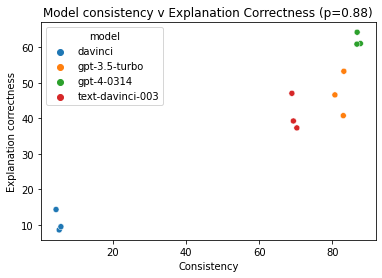

In [148]:
ax = sns.scatterplot(to_corr_df,
    x='ground_truth_consistent', y='rule_matches_sequence', hue='model'
)
ax.set(xlabel='Consistency', ylabel='Explanation correctness')
ax.set(title='Model consistency v Explanation Correctness (p=0.88)')

[Text(0.5, 1.0, 'Consistency (Self comparison) v Explanation Correctness (p=-0.62)')]

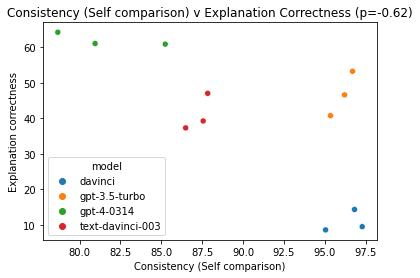

In [149]:
ax = sns.scatterplot(to_corr_df,
    x='self_comparison_consistency', y='rule_matches_sequence', hue='model')
ax.set(xlabel='Consistency (Self comparison)', ylabel='Explanation correctness')
ax.set(title='Consistency (Self comparison) v Explanation Correctness (p=-0.62)')

[Text(0.5, 1.0, 'Consistency v Sequence completion correctness (p=0.94)')]

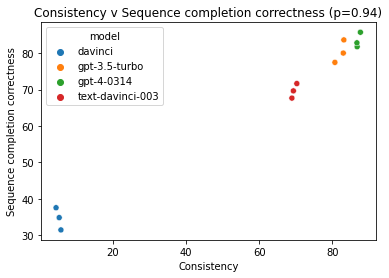

In [150]:
ax = sns.scatterplot(to_corr_df,
    x='ground_truth_consistent', y='completion_is_correct', hue='model'
)
ax.set(xlabel='Consistency', ylabel='Sequence completion correctness')
ax.set(title='Consistency v Sequence completion correctness (p=0.94)')

[Text(0.5, 1.0, 'Consistency (Self comparison) v Sequence completion correctness (p=-0.52)')]

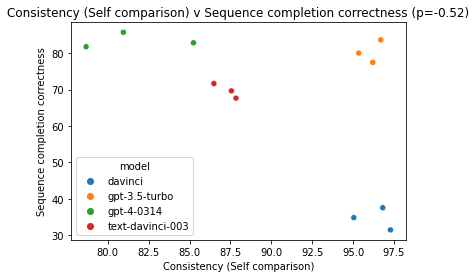

In [151]:
ax = sns.scatterplot(to_corr_df,
    x='self_comparison_consistency', y='completion_is_correct', hue='model')
ax.set(xlabel='Consistency (Self comparison)', ylabel='Sequence completion correctness')
ax.set(title='Consistency (Self comparison) v Sequence completion correctness (p=-0.52)')